In [1]:
import sys
PATH_TO_PROJECT = "/home/tanawatp/Documents/Hexapod/PhysicalAI_modelling"
sys.path.append(PATH_TO_PROJECT)
from UtilsFunction.UtilsFunc import*
from UtilsFunction.KinematicsFunc import*
from pydrake.trajectories import PiecewisePolynomial
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def InitTrajectories(p_start, p_final, v_start, v_final, total_time):
    time = np.array([0.0, total_time])
    trajs = []
    for i in range(len(p_start)):
        base_P_st = np.array([[p_start[i],p_final[i]]])
        base_V_st = np.array([[v_start[i],v_final[i]]])
        trajs.append(PiecewisePolynomial.CubicHermite(time, base_P_st, base_V_st))
    return trajs

In [3]:
desired_base_height = 0.1
desired_leg_lenght = 0.35

### Base  Trajectory

In [4]:
avg_x_d = 0.15 # m/s
step_length = 0.2
step_time = np.ceil(step_length*100 / avg_x_d)*0.01
p_start = np.array([0.5*step_length, 0, 0])
v_start = np.array([0, 0, 0])
p_final = np.array([-0.5*step_length, 0, 0])
v_final = np.array([0, 0, 0])
base_traj = InitTrajectories(p_start, p_final, v_start, v_final, step_time)
base_traj_x = base_traj[0]
curr_t = 0.0
dt = 0.01
base_P_st = []
base_V_st = []
timestamp = []
while curr_t <= step_time:
    base_P_st.append(base_traj_x.value(curr_t)[0][0])
    base_V_st.append(base_traj_x.EvalDerivative(curr_t, 1)[0][0])
    timestamp.append(curr_t)
    curr_t+=dt


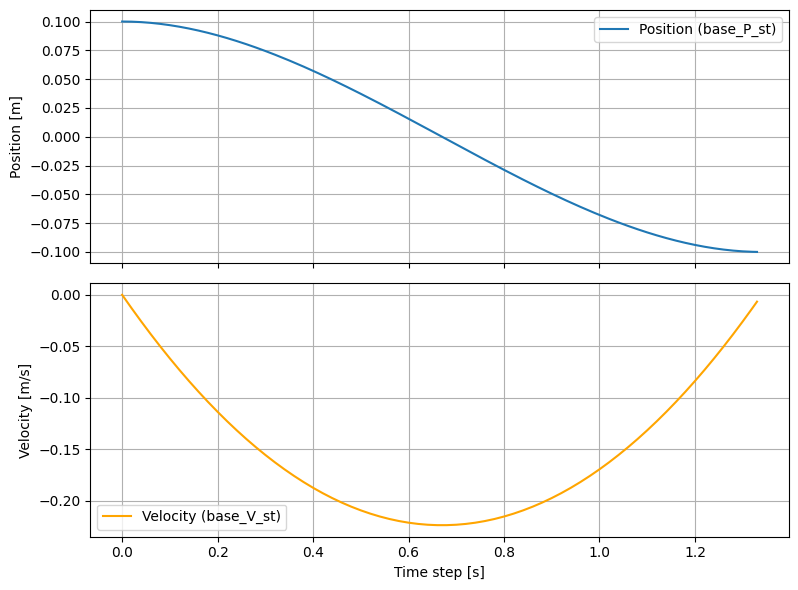

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(timestamp,base_P_st, label='Position (base_P_st)')
axs[0].set_ylabel('Position [m]')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(timestamp,base_V_st, label='Velocity (base_V_st)', color='orange')
axs[1].set_xlabel('Time step [s]')
axs[1].set_ylabel('Velocity [m/s]')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Swing Leg Trajectory

In [6]:
from pydrake.systems.framework import DiagramBuilder
from UtilsFunction.CubicTrajectory3D import CubicTrajectory3D
from UtilsFunction.DummyParameters2 import DummyParameters2
from pydrake.systems.analysis import Simulator
def CalcSwingLegtrajectory(swing_high, step_length, step_time, t0_swing, t_swing): 
    builder = DiagramBuilder()
    dummy_system = builder.AddNamedSystem("dummy param",DummyParameters2(T0_swing=t0_swing,T_swing=t_swing,step_lenght=step_length))
    traj = CubicTrajectory3D()
    traj_system = builder.AddNamedSystem("traj",traj)
    traj_system.z_max = swing_high

    for i in range(3):
        builder.Connect(dummy_system.get_output_port(i),traj_system.get_input_port(i))
    traj_logger = LogVectorOutput(traj_system.get_output_port(0), builder)
    traj_vel_logger = LogVectorOutput(traj_system.get_output_port(1), builder) 
    diagram = builder.Build()
    simulator = Simulator(diagram)
    # Run the simulation.
    context = diagram.CreateDefaultContext()
    simulator.reset_context(context)
    simulator.Initialize()
    simulator.AdvanceTo(step_time)

    log = traj_logger.FindLog(context)
    log_vel = traj_vel_logger.FindLog(context)
    swX = log.data()[0]
    swY = log.data()[1]
    swZ = log.data()[2]
    base_P_sw = np.array([swX,swY,swZ]).T
    swXd = log_vel.data()[0]
    swYd = log_vel.data()[1]
    swZd = log_vel.data()[2]
    base_V_sw = np.array([swXd,swYd,swZd]).T
    return base_P_sw, base_V_sw

In [7]:
step_height = 0.05
base_P_sw, base_V_sw = CalcSwingLegtrajectory(swing_high=step_height,
                                            step_length=step_length*0.5,
                                            step_time=step_time,
                                            t0_swing=0.0,
                                            t_swing=step_time)

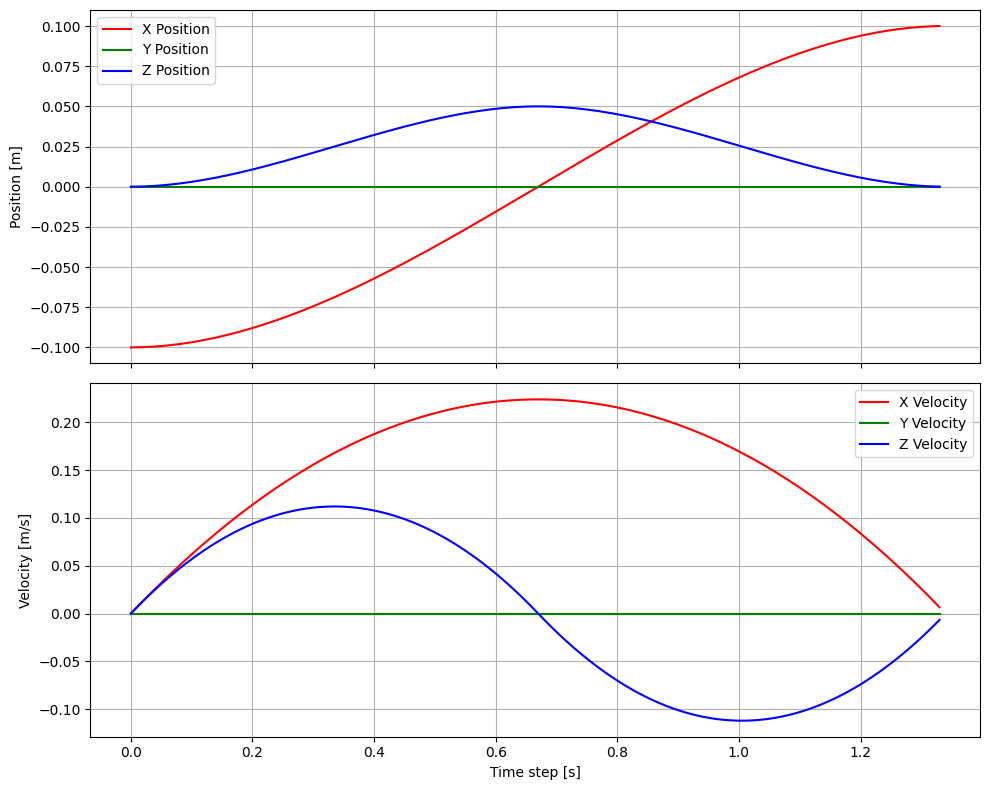

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(timestamp,base_P_sw[1:, 0]-(0.5*step_length), label='X Position', color='red')
axs[0].plot(timestamp,base_P_sw[1:, 1], label='Y Position', color='green')
axs[0].plot(timestamp,base_P_sw[1:, 2], label='Z Position', color='blue')
axs[0].set_ylabel('Position [m]')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(timestamp,base_V_sw[1:, 0], label='X Velocity', color='red')
axs[1].plot(timestamp,base_V_sw[1:, 1], label='Y Velocity', color='green')
axs[1].plot(timestamp,base_V_sw[1:, 2], label='Z Velocity', color='blue')
axs[1].set_xlabel('Time step [s]')
axs[1].set_ylabel('Velocity [m/s]')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Invertse Kinematics

In [9]:
base_P_st_x = np.array(base_P_st)
base_V_st_x = np.array(base_V_st)
base_P_sw = base_P_sw[1:,:]
base_V_sw = base_V_sw[1:,:]
plant,robot_ind = DefinePlant(model_name="Hexapod_mockup",
                    is_fixed=True,
                    fixed_frame="BaseLink")

end_effector_names = [
                    "front_left_Endeffector",  "front_right_Endeffector",
                    "middle_left_Endeffector", "middle_right_Endeffector",
                    "rear_left_Endeffector",   "rear_right_Endeffector"]
hip_offset_angle = [ 
                    -np.pi/3.0,     -2.0*np.pi/3.0, 
                    0,              -np.pi, 
                    -5.0*np.pi/3.0, -4.0*np.pi/3.0]
gait_pattern = np.array([0,1,
                         1,0,
                         0,1]) # 0 is stance leg, 1 is swing leg
base_frame = plant.GetFrameByName("BaseLink")
q_st = []
qd_st = []
initial_guess = np.ones(plant.num_positions())*0.0
# Stance legs
for t in range(len(timestamp)):
    IK_solver = InverseKinematics(plant)
    # Add position constraints
    i = 2 # middle_left_Endeffector
    # Update trajectories 
    # base_P_eff_x = gait_pattern[i]*base_P_sw[0,t] + (1-gait_pattern[i])*base_P_st_x[t]
    # base_P_eff_y = desired_leg_lenght
    # base_P_eff_z = gait_pattern[i]*(desired_base_height-base_P_sw[2,t]) + (1-gait_pattern[i])*desired_base_height
    end_effector_frame = plant.GetFrameByName(end_effector_names[i])
    # Frame transformation
    eff_P_base = RotationMatrix.MakeZRotation(hip_offset_angle[i]) @ np.array([base_P_st_x[t],
                                                                                desired_leg_lenght,
                                                                                -1.0*desired_base_height])
    IK_solver.AddPositionConstraint(
        frameB=end_effector_frame,
        p_BQ=np.zeros(3),     # point in end-effector frame
        frameA=base_frame,
        p_AQ_lower=eff_P_base-0.00001,
        p_AQ_upper=eff_P_base+0.00001
    )
    q_variables = IK_solver.q()
    # for i in range(plant.num_positions()):
    # for i in [0,3,6,9,12,15]:
    #     IK_solver.prog().AddBoundingBoxConstraint(-2.0*np.pi/3.0, 2.0*np.pi/3.0, q_variables[i])
     
    result = Solve(IK_solver.prog(),initial_guess)
    if result.is_success():
        q_solution = result.GetSolution(q_variables)
        q_st.append(q_solution[3:6])
        initial_guess = q_solution
    else:
        print("Fail to find IK!")
    

q_st = np.array(q_st)
dt = 0.01
for t in range(len(timestamp)-1):
    qd_st.append((q_st[t+1,:] - q_st[t,:])/dt)
qd_st = np.array(qd_st)

In [10]:
ListJointsName(plant=plant,model_instance_index=robot_ind)

GetJointIndices:  [JointIndex(0), JointIndex(1), JointIndex(2), JointIndex(3), JointIndex(4), JointIndex(5), JointIndex(6), JointIndex(7), JointIndex(8), JointIndex(9), JointIndex(10), JointIndex(11), JointIndex(12), JointIndex(13), JointIndex(14), JointIndex(15), JointIndex(16), JointIndex(17), JointIndex(18), JointIndex(19), JointIndex(20), JointIndex(21), JointIndex(22), JointIndex(23), JointIndex(24), JointIndex(25), JointIndex(26)]
Joint JointIndex(0): base_x_axis_offset
Joint JointIndex(1): base_z_axis_offset
Joint JointIndex(2): front_left_HeelJoint
Joint JointIndex(3): front_left_HipJoint
Joint JointIndex(4): front_left_KneeJoint
Joint JointIndex(5): front_left_Endeffector
Joint JointIndex(6): middle_left_HeelJoint
Joint JointIndex(7): middle_left_HipJoint
Joint JointIndex(8): middle_left_KneeJoint
Joint JointIndex(9): middle_left_Endeffector
Joint JointIndex(10): rear_left_HeelJoint
Joint JointIndex(11): rear_left_HipJoint
Joint JointIndex(12): rear_left_KneeJoint
Joint JointI

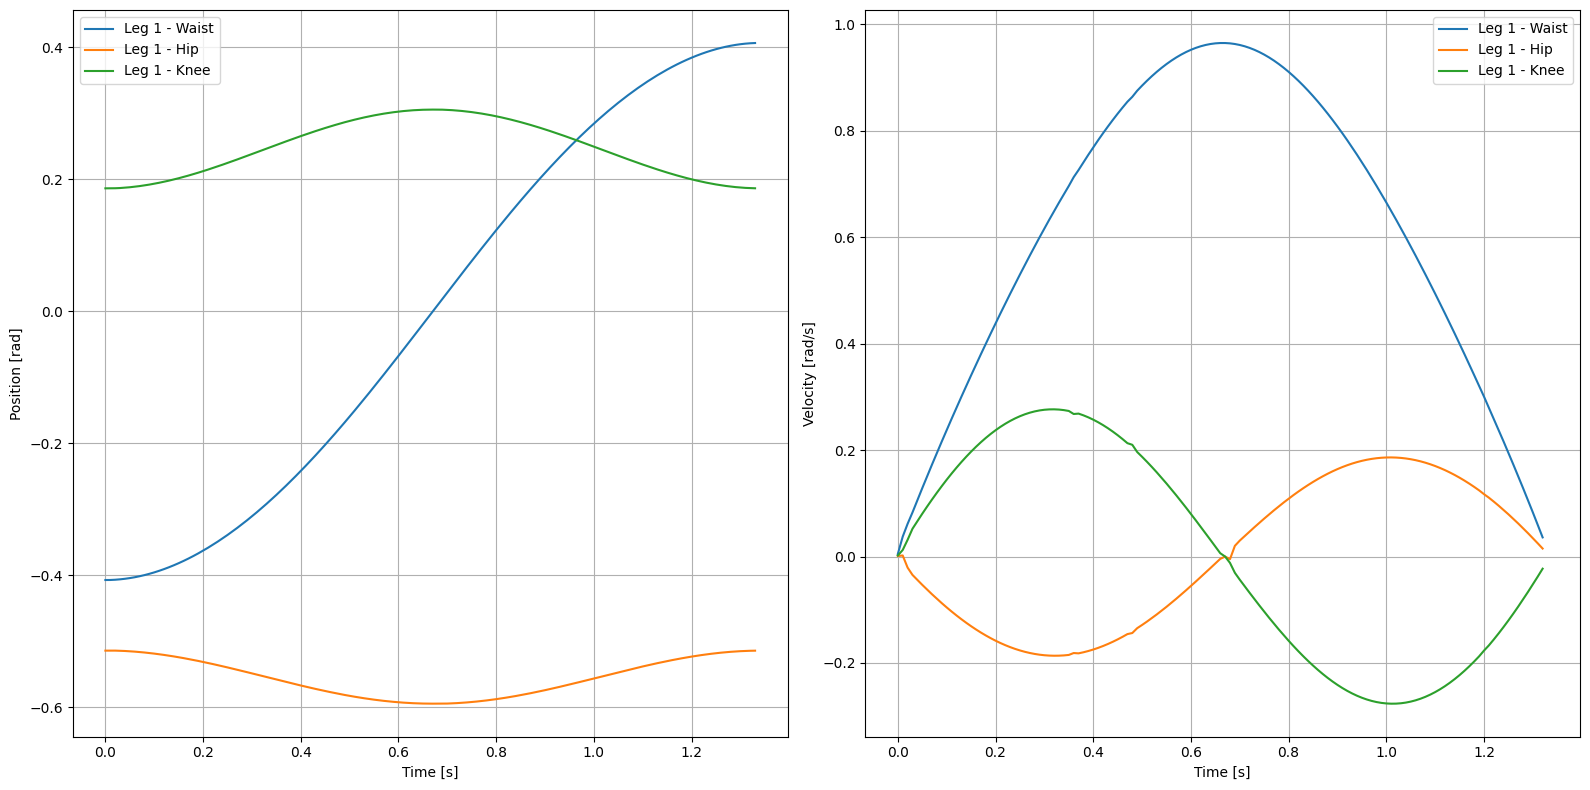

In [11]:
joint_names = ['Waist', 'Hip', 'Knee']
num_legs = 1
joints_per_leg = 3

fig, axs = plt.subplots(num_legs, 2, figsize=(16, 8), sharex=True)
if num_legs == 1:
    axs = [axs]

for leg in range(num_legs):
    # Plot joint positions
    for j in range(joints_per_leg):
        idx = leg * joints_per_leg + j
        axs[leg][0].plot(timestamp, q_st[:, idx], label=f'Leg {leg+1} - {joint_names[j]}')
    axs[leg][0].set_ylabel('Position [rad]')
    axs[leg][0].legend()
    axs[leg][0].grid(True)
    # Plot joint velocities
    for j in range(joints_per_leg):
        idx = leg * joints_per_leg + j
        axs[leg][1].plot(timestamp[:-1], qd_st[:, idx], label=f'Leg {leg+1} - {joint_names[j]}')
    axs[leg][1].set_ylabel('Velocity [rad/s]')
    axs[leg][1].legend()
    axs[leg][1].grid(True)

axs[-1][0].set_xlabel('Time [s]')
axs[-1][1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


In [12]:
q_sw = []
qd_sw = []
initial_guess = np.ones(plant.num_positions())*0.0
# Stance legs
for t in range(len(timestamp)):
    IK_solver = InverseKinematics(plant)
    # Add position constraints
    i = 2 # middle_left_Endeffector
    # Update trajectories 
    # base_P_eff_x = gait_pattern[i]*base_P_sw[0,t] + (1-gait_pattern[i])*base_P_st_x[t]
    # base_P_eff_y = desired_leg_lenght
    # base_P_eff_z = gait_pattern[i]*(desired_base_height-base_P_sw[2,t]) + (1-gait_pattern[i])*desired_base_height
    end_effector_frame = plant.GetFrameByName(end_effector_names[i])
    # Frame transformation
    eff_P_base = RotationMatrix.MakeZRotation(hip_offset_angle[i]) @ np.array([base_P_sw[t,0],
                                                                                desired_leg_lenght,
                                                                                -1.0*(desired_base_height-base_P_sw[t,2])])
    IK_solver.AddPositionConstraint(
        frameB=end_effector_frame,
        p_BQ=np.zeros(3),     # point in end-effector frame
        frameA=base_frame,
        p_AQ_lower=eff_P_base-0.00001,
        p_AQ_upper=eff_P_base+0.00001
    )
    q_variables = IK_solver.q()
    # for i in range(plant.num_positions()):
    # for i in [0,3,6,9,12,15]:
    #     IK_solver.prog().AddBoundingBoxConstraint(-2.0*np.pi/3.0, 2.0*np.pi/3.0, q_variables[i])
     
    result = Solve(IK_solver.prog(),initial_guess)
    if result.is_success():
        q_solution = result.GetSolution(q_variables)
        q_sw.append(q_solution[3:6])
        initial_guess = q_solution
    else:
        print("Fail to find IK!")

q_sw = np.array(q_sw)
dt = 0.01
for t in range(len(timestamp)-1):
    qd_sw.append((q_sw[t+1,:] - q_sw[t,:])/dt)
qd_sw = np.array(qd_sw)

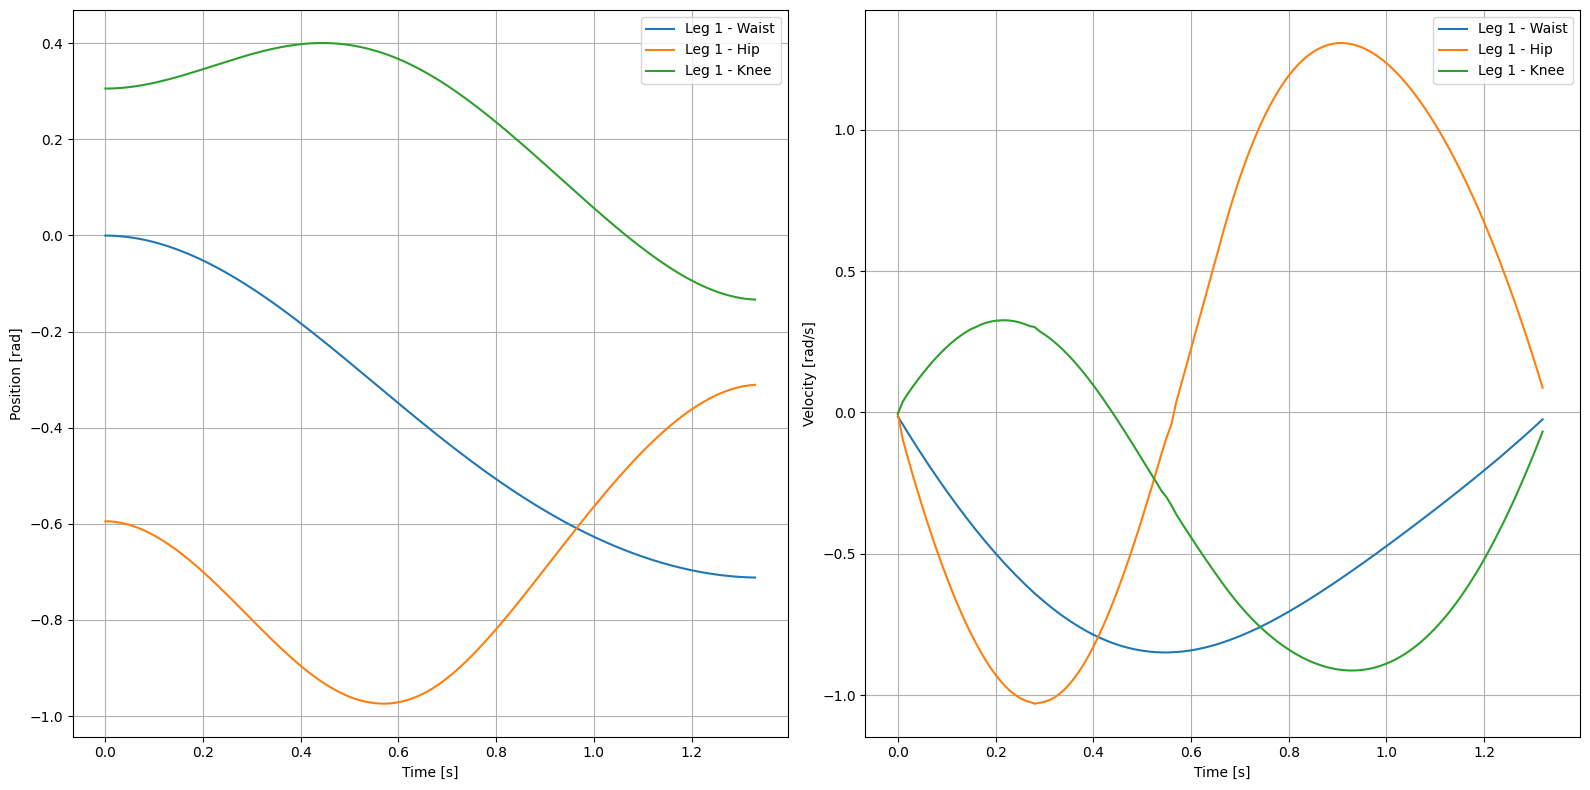

In [13]:
joint_names = ['Waist', 'Hip', 'Knee']
num_legs = 1
joints_per_leg = 3

fig, axs = plt.subplots(num_legs, 2, figsize=(16, 8), sharex=True)
if num_legs == 1:
    axs = [axs]

for leg in range(num_legs):
    # Plot joint positions
    for j in range(joints_per_leg):
        idx = leg * joints_per_leg + j
        axs[leg][0].plot(timestamp, q_sw[:, idx], label=f'Leg {leg+1} - {joint_names[j]}')
    axs[leg][0].set_ylabel('Position [rad]')
    axs[leg][0].legend()
    axs[leg][0].grid(True)
    # Plot joint velocities
    for j in range(joints_per_leg):
        idx = leg * joints_per_leg + j
        axs[leg][1].plot(timestamp[:-1], qd_sw[:, idx], label=f'Leg {leg+1} - {joint_names[j]}')
    axs[leg][1].set_ylabel('Velocity [rad/s]')
    axs[leg][1].legend()
    axs[leg][1].grid(True)

axs[-1][0].set_xlabel('Time [s]')
axs[-1][1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()